In [1]:
import qutip
import jax.numpy as jnp
import matplotlib.pyplot as plt

from qurveros.spacecurve import SpaceCurve
from qurveros import frametools, plottools
from qurveros.settings import settings

from qurveros.qubit_bench import simulator, noise_experiments
import qurveros.plot_configs
import matplotlib
import numpy as np

matplotlib.rcParams['figure.dpi'] = 150

This example will analyze the robustness properties of a doubly robust pulse.
In contrast to the circle example, the Bessel curve is defined through its 
tangent vector. 
See [PhysRevA.108.012407](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.108.012407) for details.

We start with its definition as:
\begin{align}
\vec T(t) &= \cos(\phi(t))\sin(\theta(t)) \hat x + \sin(\phi(t))\sin(\theta(t)) \hat y
        + \cos(\theta(t)) \hat z, \\
        \theta(t) &= x_i \cos(t), \\
\phi(t) &= q \,\theta(t).
\end{align}

and define the curve function:

In [2]:
def curve(x, params):
        
        # params[0] is the x_i parameter which corresponds to the zero
        # of the zero-order Bessel.
        theta = params[0]*jnp.cos(x)
        # params[1] is the value of q defined in the paper.
        phi = params[1]*theta
        
        x_comp = jnp.cos(phi)*jnp.sin(theta)
        y_comp = jnp.sin(phi)*jnp.sin(theta)
        z_comp = jnp.cos(theta)

        return [x_comp, y_comp, z_comp]

Since we need to indicate that the provided curve corresponds to the tangent
vector, we set order = 1 for this example.

The parameter values that achieve the desired robustness
properties are found in the paper.

In [3]:
spacecurve = SpaceCurve(curve=curve,
                        order=1, 
                        interval=[0, 2*jnp.pi],
                        params= [5.5201, 0.5660])

spacecurve.evaluate_frenet_dict()

The curve will be constructed using the tangent vector.


The curve is numerically integrated and results to a closed curve.

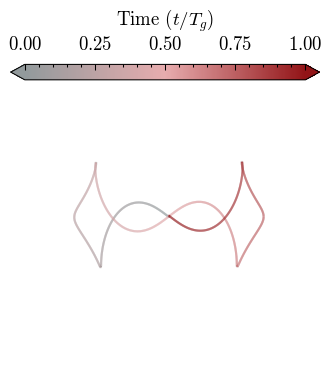

In [4]:
spacecurve.plot_position()
plt.gca().view_init(elev=-40,azim=90)

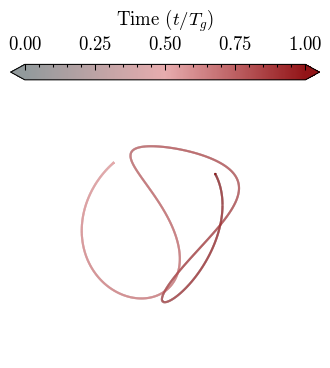

In [5]:
spacecurve.plot_tantrix()
plt.gca().view_init(elev=20,azim=-70)

The tangent vector demonstrates the required symmetry for driving field error
robustness.
See [PhysRevA.108.012407](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.108.012407) for details.

We can confirm our visual intuition by evaluating the robustness
properties.

In [6]:
spacecurve.evaluate_robustness_properties()
spacecurve.get_robustness_properties()

|       closed_test       : 	 1.2340e-06
|     curve_area_test     : 	 1.4631e-34
|    tantrix_area_test    : 	 7.8963e-31
|           CFI           : 	 9.2876e-03


As we traverse the tangent curve, the total (oriented) area projected in three
orthogonal directions vanishes, which corresponds to multiplicative 
driving field error robustness.

See [PhysRevA.108.012407](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.108.012407) for details.

For single-qubit control, we consider the general control Hamiltonian of the
form:
\begin{align}
H_0 = \frac{\Omega(t)}{2}[\cos\Phi(t)\sigma_x + \sin\Phi(t)\sigma_y] + \frac{\Delta(t)}{2}\sigma_z,
\end{align}

and associate the fields for each axis as:
\begin{align}
\Omega_x &= \Omega \cos\Phi, \\
\Omega_y &= \Omega \sin\Phi .
\end{align}

In this example, we use resonant control.

In [7]:
spacecurve.evaluate_control_dict('XY')

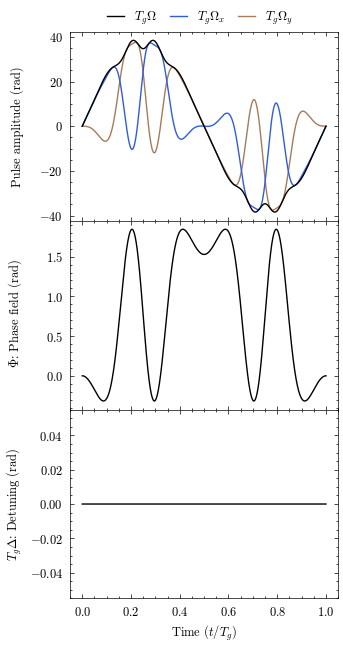

In [8]:
spacecurve.plot_fields('full')
plt.gcf().set_dpi(100)

To numerically validate the robustness properties of the curve, 
we will use the subpackage `qubit_bench`.

We can define the target unitary using `qutip`.

In [9]:
u_target = qutip.Qobj(jnp.eye(2))

In [10]:
control_dict = spacecurve.get_control_dict()

The `qubit_bench` subpackage provides the `simulator` module to simulate the
generated control dict.

In [11]:
sim_dict = simulator.simulate_control_dict(control_dict, u_target)

The average gate fidelity is provided as an entry of the returned dictionary 
using the definition from 
Fidelity of quantum operations by Pedersen et al.
https://doi.org/10.1016/j.physleta.2007.02.069.

In [12]:
jnp.set_printoptions(20)
np.set_printoptions(20)

In [13]:
sim_dict['avg_gate_fidelity']

0.9999999999999153

We can compare it with the average gate fidelity found using the
adjoint representation, which is calculated in the control dictionary.

The adjoint representation of a unitary $U$ is defined as:
\begin{align}
    R_U^{ij} = \frac{1}{2}\text{tr}(U^\dagger\sigma_iU\sigma_j).
\end{align}

In [14]:
control_dict['adj_curve']

Array([[ 1.0000000000000002e+00, -1.8471154928396503e-11,
        -1.8213571770566528e-19],
       [ 1.8471213454767271e-11,  1.0000000000000004e+00,
        -7.2789219901228933e-17],
       [ 1.2133778671142379e-17, -8.8654086416685446e-17,
         1.0000000000000000e+00]], dtype=float64)

In [15]:
sim_dict['adj_final']

array([[ 9.999999999999154e-01,  8.843905964658829e-13,
        -7.291296138729175e-13],
       [-8.843905964665065e-13,  9.999999999999154e-01,
        -8.552116458675947e-13],
       [ 7.291296138721611e-13,  8.552116458682395e-13,
         9.999999999999154e-01]])

Given their relatively close values, the respective fidelities will match
the expected nearly-unit values.

The average gate fidelity from the simulation using the adjoint
representation can be found by:

\begin{align}
    \mathcal{F}_g(U_0(T_g)) = \frac{d+1+\text{tr}(R_g^T R_{U_0}(T_g))}{d(d+1)}
\end{align}

where $R_g$ is the adjoint representation of the target unitary $U_g$ 
stored in the variable `u_target` and $R_{U_0}(T_g)$ is the adjoint
representation of our implemented control at $t=T_g$.

In [16]:
frametools.calculate_adj_fidelity(sim_dict['adj_final'], sim_dict['adj_target'])

Array(0.9999999999999576, dtype=float64)

We can now validate that the gate was designed correctly by finding
the average gate fidelity between the expected adjoint representation
(found using SCQC without simulation) stored in `adj_curve` and 
the target adjoint representation.

In [17]:
frametools.calculate_adj_fidelity(sim_dict['adj_target'], control_dict['adj_curve'])

Array(1., dtype=float64)

Finally, we validate that the predicted adjoint representation matches
the simulation result closely.

In [18]:
frametools.calculate_adj_fidelity(sim_dict['adj_final'], control_dict['adj_curve'])

Array(0.9999999999999578, dtype=float64)

Let's confirm the robustness properties by simulating the control dict.

The `qubit_bench` subpackage provide the `noise_experiments` module that
performs the robustness tests.

In [19]:
multi_source_dict = noise_experiments.simult_source_experiment(control_dict, 
                                                               u_target)

Static additive dephasing and multiplicative driving field experiment



Multiplicative driving field error:	 0.00 %
Multiplicative driving field error:	 8.33 %                                   
Multiplicative driving field error:	16.67 %                                   
Multiplicative driving field error:	25.00 %                                   
Multiplicative driving field error:	33.33 %                                   
Multiplicative driving field error:	41.67 %                                   
Multiplicative driving field error:	50.00 %                                   
Multiplicative driving field error:	58.33 %                                   
Multiplicative driving field error:	66.67 %                                   
Multiplicative driving field error:	75.00 %                                   
Multiplicative driving field error:	83.33 %                                   
Multiplicative driving field error:	91.67 %                                   
Multiplicative driving field error:	100.00%                                   


In [20]:
multi_source_dict['experiment']

'static additive dephasing and multiplicative driving field experiment'

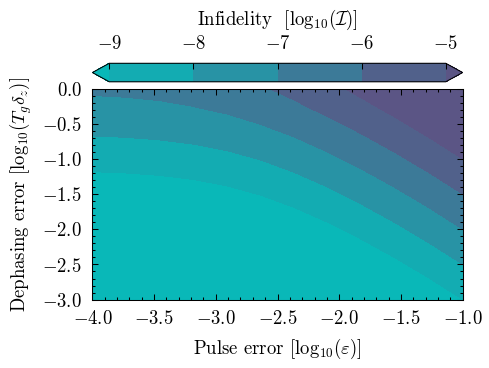

In [21]:
plottools.plot_noise_contour(multi_source_dict)

With this plot, we validate the doubly robust nature of the derived pulses.

In the next examples, we will dive into space curve optimization.

In [22]:
print(settings)

    CURVE_POINTS    : 	 4096
     SIM_POINTS     : 	 4096
   QUTIP_OPTIONS    : 	 {'max_step': 0.0001220703125, 'atol': 1e-14, 'rtol': 1e-14}
  NUM_REALIZATIONS  : 	 200
 FIR_TERMS_FRACTION : 	 0.9
  DELTA_Z_INTERVAL  : 	 (-3, 0)
  EPSILON_INTERVAL  : 	 (-4, -1)
     MAX_POINTS     : 	 12
  COUNTOUR_LEVELS   : 	 (-9, -8, -7, -6, -5)
     NUM_DERIVS     : 	 5
  INFLECTION_NORM   : 	 0.001
      FIX_NORM      : 	 0.01
     NUM_SINGLS     : 	 5
    ANGLE_K_MAX     : 	 3
    FIELD_NAMES     : 	 ['omega', 'phi', 'delta']
     OPT_POINTS     : 	 4096
    CURVE_COLORS    : 	 ['#929A9C', '#E7ACAE', '#921417']
    FIELD_COLORS    : 	 ['#000000', '#305CDE', '#A67B5B']
  COUNTOUR_COLORS   : 	 ['#09B8B8', '#5B5585']

